# Playing with kernels in GPs

We re-run the notebook, now with x-range [0,4], to show that linear kernel is not a good option.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import GPy

### Setting up the problem, and training data

Simple 1D example, where the truth is a sinusoidal function, and we'll have a few noisy training points. 

In [2]:
# define truth underlying function we are trying to model
def true_function(x):
    return np.sin(1.2*x)

In [3]:
# define test data (_s stands for \star)
x_min=0
x_max=x_min+4
n_s = 81
x_s = np.linspace(x_min,x_max,n_s).reshape(-1,1)

In [4]:
# training data (_t stands for training)
x_t = [x_min+0.4,x_min+0.5,x_min+0.6,x_min+1,x_min+2.5,x_min+3]
n_t = len(x_t)
x_t = np.array(x_t).reshape(n_t,1)
# noise variance
noise_var=1.e-2
noise_rms=np.sqrt(noise_var)
y_t = true_function(x_t) + noise_rms*np.random.normal(size=[n_t,1])

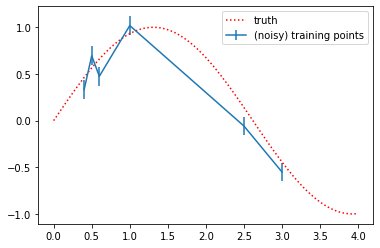

In [5]:
plt.errorbar(x_t,y_t,yerr=noise_rms*np.ones(n_t),label='(noisy) training points')
plt.plot(x_s,true_function(x_s),':',color='red',label='truth')
plt.legend()
plt.show()

### Squared-Exponential kernel (or RBF)

In [6]:
# decide whether to optimise noise variance or use true value
fix_noise_var=False

In [7]:
# setup RBF kernel
k_RBF = GPy.kern.RBF(input_dim=1)

In [8]:
# setup main GP model
m_RBF = GPy.models.GPRegression(x_t,y_t,k_RBF,noise_var=noise_var)
print('log marginal likelihood',m_RBF.log_likelihood())
if fix_noise_var:
    m_RBF.Gaussian_noise.variance.fix()

log marginal likelihood -4.084717581696437


In [9]:
m_RBF.optimize(messages=True)

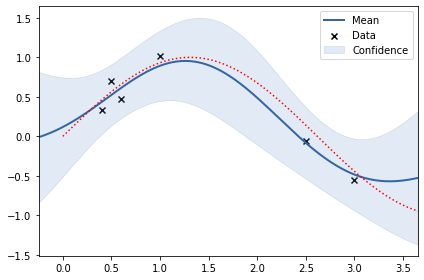

In [10]:
fig = m_RBF.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

This worked quite well. Depending on the random seed, some of the hyper-parameters are not properly fitted (the noise variance, for instance, should not move from its true value), but this is expected. If we have fewer points, it is even harder to fit them. Let's try now with a linear kernel!

### Dot kernel (or linear)

$K(x_1,x_2) = \sigma_L^2 x_1 x_2$

This kernel is useful in linear model, i.e., it could be useful when doing first-order Taylor expansions around a fiducial model.

In [11]:
k_lin = GPy.kern.Linear(input_dim=1,variances=1.0,ARD=False)

In [12]:
# setup main GP object
m_lin = GPy.models.GPRegression(x_t,y_t,k_lin,noise_var=noise_var)
print('log marginal likelihood',m_lin.log_likelihood())
if fix_noise_var:
    m_lin.Gaussian_noise.variance.fix()

log marginal likelihood -103.42124303193397


In [13]:
m_lin.optimize(messages=True)

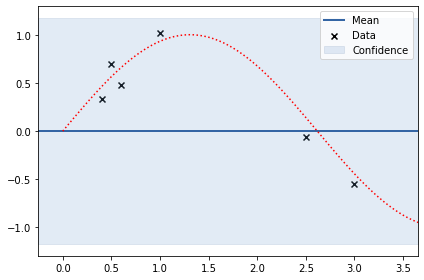

In [14]:
fig = m_lin.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

Now the function is not well approximated by a linear model, and the linear kernel fails. This is a situation similar to the one in our P1D problem, since our parameters are defined in the range [0,1] and the fiducial model that we should be Taylor-expanding around is somewhere near x=0.5.